# Baseline модель

In [84]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from collections import Counter
from sklearn.feature_extraction import text

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
categories_path = '/content/drive/MyDrive/maxidom_contest/data/categories.csv'
offers_expanded_path = '/content/drive/MyDrive/maxidom_contest/data/offers_expanded.csv'
promos_path = '/content/drive/MyDrive/maxidom_contest/data/promos.csv'
offers_path = '/content/drive/MyDrive/maxidom_contest/data/offers.csv'

In [86]:
offers_expanded = pd.read_csv(offers_path)
categories = pd.read_csv(categories_path)
promos = pd.read_csv(promos_path)
offers = pd.read_csv(offers_path)

In [87]:
promo_counts = promos.groupby('offer_id').size().reset_index(name='promo_count')

baseline_df = offers.merge(promo_counts, on='offer_id', how='left')
baseline_df['promo_count'] = baseline_df['promo_count'].fillna(0)

baseline_df = baseline_df.merge(
    categories[['category_id', 'name']],
    on='category_id',
    how='left',
    suffixes=('', '_category')
)

baseline_df['popularity_score'] = (
    baseline_df['promo_count'] / baseline_df['promo_count'].max() * 0.6 +
    (1 - baseline_df['price'] / baseline_df['price'].max()) * 0.4
)

top_products = baseline_df.nlargest(20, 'popularity_score')[
    ['offer_id', 'name', 'vendor', 'price', 'promo_count', 'popularity_score']
]

print("BASELINE: ТОП-20 ПОПУЛЯРНЫХ ТОВАРОВ")
print("─" * 100)
print(top_products.to_string(index=False))

print("\n" + "─" * 100)
print("СТАТИСТИКА BASELINE")
print("─" * 100)
print(f"Средний popularity_score: {baseline_df['popularity_score'].mean():.4f}")
print(f"Медианный popularity_score: {baseline_df['popularity_score'].median():.4f}")
print(f"Товаров с промо: {(baseline_df['promo_count'] > 0).sum():,}")
print(f"Товаров без промо: {(baseline_df['promo_count'] == 0).sum():,}")

BASELINE: ТОП-20 ПОПУЛЯРНЫХ ТОВАРОВ
────────────────────────────────────────────────────────────────────────────────────────────────────
 offer_id                                                                      name    vendor  price  promo_count  popularity_score
  9412612                                     пакет Майка ПНД 270х450 12мкм до 5 кг Нет марки    4.0          1.0          0.999992
  9702706                                                     муфта PPR РОСТерм d20   РОСТЕРМ    4.0          1.0          0.999992
  9702730                                                    пробка PPR РОСТерм d20   РОСТЕРМ    4.0          1.0          0.999992
  9702834                                             угольник PPR РОСТерм d20 45гр   РОСТЕРМ    4.0          1.0          0.999992
  5427018                    семена морковь Витаминная 6 ДОМ СЕМЯН 2,3г белый пакет ДОМ СЕМЯН    5.0          1.0          0.999990
  9702710                                                     муфта PPR

# TF IDF baseline


СПИСОК СТОП-СЛОВ ДЛЯ TF IDF

In [88]:
russian_stopwords = [
    'это', 'все', 'такой', 'такая', 'такое', 'такие', 'этот', 'эта', 'это',
    'который', 'которая', 'которые', 'которое', 'очень', 'также', 'так',
    'ну', 'вот', 'еще', 'ещё', 'много', 'мало', 'можно', 'надо', 'нужно',
    'есть', 'быть', 'мочь', 'свой', 'своя', 'свое', 'свои', 'самый',
    'самая', 'самое', 'самые', 'можно', 'нельзя', 'разный', 'разная',
    'разное', 'разные', 'некоторый', 'некоторая', 'некоторое', 'некоторые',
    'какой', 'какая', 'какое', 'какие', 'какойто', 'какаято', 'какоето',
    'какието', 'чтото', 'чтолибо', 'коечто', 'нибудь', 'либо', 'както',
    'таке', 'также', 'итак', 'кстати', 'вообще', 'вероятно', 'возможно',
    'пожалуй', 'конечно', 'наверное', 'наверно', 'может', 'можетбыть',
    'кажется', 'вроде', 'вродебы', 'собственно', 'действительно',
    'например', 'пример', 'скажем', 'допустим', 'значит', 'всегда',
    'часто', 'редко', 'никогда', 'иногда', 'обычно', 'обыкновенно',
    'постоянно', 'всего', 'лишь', 'только', 'почти', 'примерно',
    'приблизительно', 'около', 'точно', 'ровно', 'совсем', 'абсолютно',
    'полностью', 'целиком', 'вполне', 'достаточно', 'недостаточно',
    'слишком', 'очень', 'чрезвычайно', 'крайне', 'совершенно',
]

technical_stopwords = [
    'br', 'div', 'span', 'p', 'html', 'body', 'nbsp', 'strong', 'b', 'i', 'em',
    'ul', 'li', 'ol', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'class', 'style',
    'href', 'src', 'alt', 'title', 'width', 'height', 'border', 'color',
    'background', 'font', 'size', 'align', 'valign', 'target', 'rel'
]

additional_prepositions = [
    'для', 'мм', 'материал', 'на', 'из', 'цвет', 'см', 'размер', 'тип',
    'белый', 'от', 'марки', 'да', 'нет', 'и', 'в', 'с', 'у', 'о', 'без',
    'до', 'за', 'из', 'к', 'на', 'над', 'о', 'об', 'от', 'по', 'под',
    'при', 'про', 'с', 'со', 'у', 'через', 'или', 'что'
]

custom_stopwords = list(text.ENGLISH_STOP_WORDS) + russian_stopwords + technical_stopwords + additional_prepositions

custom_stopwords = list(set(custom_stopwords))
print(f"Используется {len(custom_stopwords)} стоп-слов")

Используется 495 стоп-слов


СОЗДАНИЕ И ПОДГОТОВКА ДАТАФРЕЙМА ДЛЯ TF-IDF

In [89]:
tfidf_df = offers.copy()

tfidf_df = tfidf_df.merge(
    categories[['category_id', 'name']],
    on='category_id',
    how='left',
    suffixes=('', '_category')
)

In [90]:
tfidf_df['market_description'] = tfidf_df['market_description'].fillna('')
tfidf_df['description'] = tfidf_df['description'].fillna('')
tfidf_df['name_category'] = tfidf_df['name_category'].fillna('')

ФУНКЦИЯ ОТЧИСТКИ ДАННЫХ

In [91]:
def clean_text(text):
    if not isinstance(text, str):
        return ''

    text = re.sub(r'<[^>]+>', ' ', text)

    text = re.sub(r'&[a-z]+;', ' ', text)

    text = text.lower()

    text = re.sub(r'[^\w\sа-яА-ЯёЁ]', ' ', text)

    text = re.sub(r'\b[а-яё]\b', ' ', text)

    text = re.sub(r'\b[а-яё]{1,2}\b', ' ', text)

    text = re.sub(r'\s+', ' ', text)

    return text.strip()

СОЗДАНИЕ КОМБИНИРОВАННЫХ ПРИЗНАКОВ

In [92]:
tfidf_df['combined_features'] = (
    tfidf_df['name'].apply(clean_text) + ' ' +
    tfidf_df['description'].apply(clean_text) + ' ' +
    tfidf_df['market_description'].apply(clean_text) + ' ' +
    tfidf_df['name_category'].apply(clean_text) + ' ' +
    tfidf_df['vendor'].apply(clean_text)
)

In [93]:
print(f"Создано комбинированных текстовых признаков: {len(tfidf_df):,}")
print(f"\nПример combined_features для первого товара:")
print(f"{tfidf_df['combined_features'].iloc[0][:200]}")


Создано комбинированных текстовых признаков: 64,490

Пример combined_features для первого товара:
бумага svetocopy a4 500л svetocopy формат а4 500 листов  бумага для офисной техники нет марки


СОЗДАНИЕ TF-IDF МАТРИЦЫ

In [94]:
tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words=custom_stopwords,
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.8
    )

tfidf_matrix = tfidf_vectorizer.fit_transform(tfidf_df['combined_features'])

print(f"Размер TF-IDF матрицы: {tfidf_matrix.shape}")
print(f"Количество товаров: {tfidf_matrix.shape[0]:,}")
print(f"Количество признаков (слов): {tfidf_matrix.shape[1]:,}")
print(f"Разреженность матрицы: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%")

Размер TF-IDF матрицы: (64490, 5000)
Количество товаров: 64,490
Количество признаков (слов): 5,000
Разреженность матрицы: 99.28%


In [95]:
feature_names = tfidf_vectorizer.get_feature_names_out()
mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()

tfidf_features_df = pd.DataFrame({
    'feature': feature_names,
    'mean_tfidf': mean_tfidf
}).sort_values('mean_tfidf', ascending=False)

ТОП-20 САМЫХ ВАЖНЫХ ПРИЗНАКОВ В TF-IDF

In [96]:
print(tfidf_features_df.head(20).to_string(index=False))

   feature  mean_tfidf
   пластик    0.014497
     сталь    0.014059
количество    0.014017
     длина    0.012687
   диаметр    0.012527
 коллекция    0.011333
   maxijoy    0.011108
    черный    0.010046
    стекло    0.010018
     объем    0.009897
       арт    0.009871
        10    0.009648
       пвх    0.009435
       100    0.009275
  упаковке    0.009198
    металл    0.009068
 позволяет    0.008651
    ширина    0.008635
    высота    0.008479
       вес    0.008363


ГРАФИК ТОП-20 НАИБОЛЕЕ ЗНАЧИМЫХ ПРИЗНАКОВ ДЛЯ МОДЕЛИ В TF-IDF

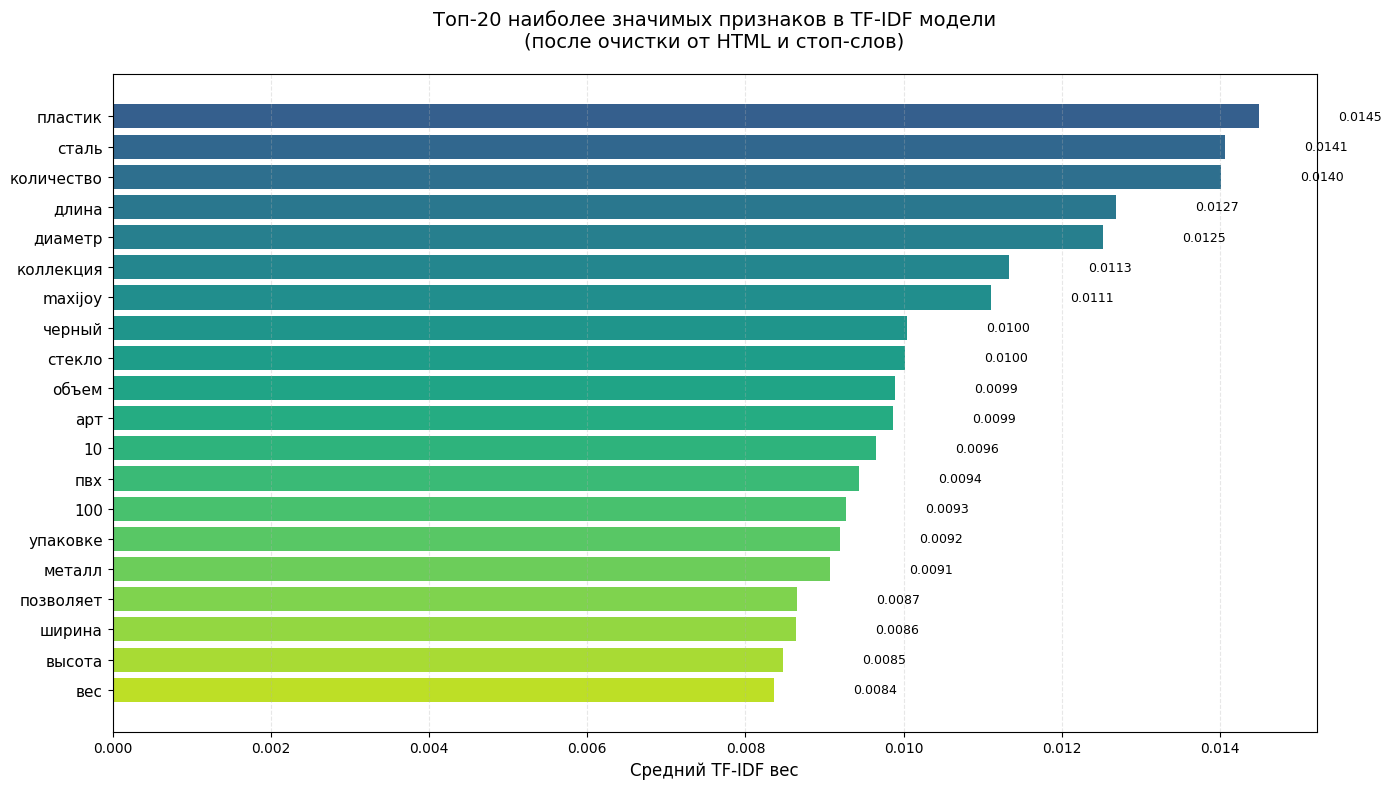

In [97]:
fig, ax = plt.subplots(figsize=(14, 8))
top_20_features = tfidf_features_df.head(20)
bars = ax.barh(range(len(top_20_features)), top_20_features['mean_tfidf'].values,
               color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top_20_features))))
ax.set_yticks(range(len(top_20_features)))
ax.set_yticklabels(top_20_features['feature'].values, fontsize=11)
ax.set_xlabel('Средний TF-IDF вес', fontsize=12)
ax.set_title('Топ-20 наиболее значимых признаков в TF-IDF модели\n(после очистки от HTML и стоп-слов)', fontsize=14, pad=20)

for i, (bar, value) in enumerate(zip(bars, top_20_features['mean_tfidf'].values)):
    ax.text(value + 0.001, bar.get_y() + bar.get_height()/2,
            f'{value:.4f}', ha='left', va='center', fontsize=9)

ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

АНАЛИЗ РАСПРЕДЕЛЕНИЯ N-ГРАММ

In [98]:
features = tfidf_features_df['feature'].tolist()
unigrams = sum(1 for f in features if len(f.split()) == 1)
bigrams = sum(1 for f in features if len(f.split()) == 2)
trigrams = sum(1 for f in features if len(f.split()) == 3)

print(f"Уникальных признаков: {len(features):,}")
print(f"   • Униграмм (1 слово): {unigrams:,} ({unigrams/len(features)*100:.1f}%)")
print(f"   • Биграмм (2 слова): {bigrams:,} ({bigrams/len(features)*100:.1f}%)")
print(f"   • Триграмм (3 слова): {trigrams:,} ({trigrams/len(features)*100:.1f}%)")

Уникальных признаков: 5,000
   • Униграмм (1 слово): 3,936 (78.7%)
   • Биграмм (2 слова): 1,064 (21.3%)
   • Триграмм (3 слова): 0 (0.0%)


ТОП-10 УНИГРАММ

In [99]:
unigrams_df = tfidf_features_df[tfidf_features_df['feature'].apply(lambda x: len(x.split()) == 1)].head(10)
for i, row in unigrams_df.iterrows():
    print(f"   {row['feature']:<25} {row['mean_tfidf']:.4f}")

   пластик                   0.0145
   сталь                     0.0141
   количество                0.0140
   длина                     0.0127
   диаметр                   0.0125
   коллекция                 0.0113
   maxijoy                   0.0111
   черный                    0.0100
   стекло                    0.0100
   объем                     0.0099


ТОП-10 БИГРАММ

In [100]:
bigrams_df = tfidf_features_df[tfidf_features_df['feature'].apply(lambda x: len(x.split()) == 2)].head(10)
for i, row in bigrams_df.iterrows():
    print(f"   {row['feature']:<35} {row['mean_tfidf']:.4f}")

   количество упаковке                 0.0064
   цветовая температура                0.0053
   нерж сталь                          0.0048
   ugo loks                            0.0036
   нержавеющая сталь                   0.0032
   ванной комнаты                      0.0032
   нержавеющей стали                   0.0031
   световой поток                      0.0031
   внешний вид                         0.0030
   посудомоечной машине                0.0029


ФУНКЦИЯ ПОЛУЧЕНИЯ РЕКОМЕНДАЦИЙ

In [102]:
def get_tfidf_recommendations(offer_id, top_n=10):
    idx = tfidf_df[tfidf_df['offer_id'] == offer_id].index

    if len(idx) == 0:
        print(f"Товар с ID {offer_id} не найден")
        return None

    idx = idx[0]

    cosine_similarities = cosine_similarity(tfidf_matrix[idx:idx+1], tfidf_matrix).flatten()

    similar_indices = cosine_similarities.argsort()[::-1][1:top_n+1]

    recommendations = tfidf_df.iloc[similar_indices][
        ['offer_id', 'name', 'vendor', 'price', 'name_category']
    ].copy()

    recommendations['similarity_score'] = cosine_similarities[similar_indices]

    return recommendations

ПРИМЕР РЕКОМЕНДАЦИЙ ДЛЯ СЛУЧАЙНОГО ТОВАРА

In [103]:
sample_offer_id = tfidf_df.sample(1)['offer_id'].values[0]
sample_product = tfidf_df[tfidf_df['offer_id'] == sample_offer_id].iloc[0]

print(f"\nИсходный товар:")
print(f"ID: {sample_product['offer_id']}")
print(f"Название: {sample_product['name']}")
print(f"Производитель: {sample_product['vendor']}")
print(f"Категория: {sample_product['name_category']}")
print(f"Цена: {sample_product['price']:.2f} руб")

print(f"\n{'─' * 100}")
print("ТОП-10 ПОХОЖИХ ТОВАРОВ:")
print("─" * 100)

recommendations = get_tfidf_recommendations(sample_offer_id, top_n=10)
print(recommendations.to_string(index=False))


Исходный товар:
ID: 11646573
Название: патрон ВЭП СВЕТ Е27 карболитовый черный
Производитель: ВЭП СВЕТ
Категория: Патроны для лампочек
Цена: 52.00 руб

────────────────────────────────────────────────────────────────────────────────────────────────────
ТОП-10 ПОХОЖИХ ТОВАРОВ:
────────────────────────────────────────────────────────────────────────────────────────────────────
 offer_id                                                                              name   vendor  price                           name_category  similarity_score
 11646577                                   патрон ВЭП СВЕТ Е27 карболитовый угловой черный ВЭП СВЕТ   95.0                    Патроны для лампочек          0.981349
 11646581                         патрон ВЭП СВЕТ Е27 карболитовый прямой потолочный черный ВЭП СВЕТ   80.0                    Патроны для лампочек          0.966579
 11646569                                            патрон ВЭП СВЕТ Е27 керамический белый ВЭП СВЕТ   32.0                

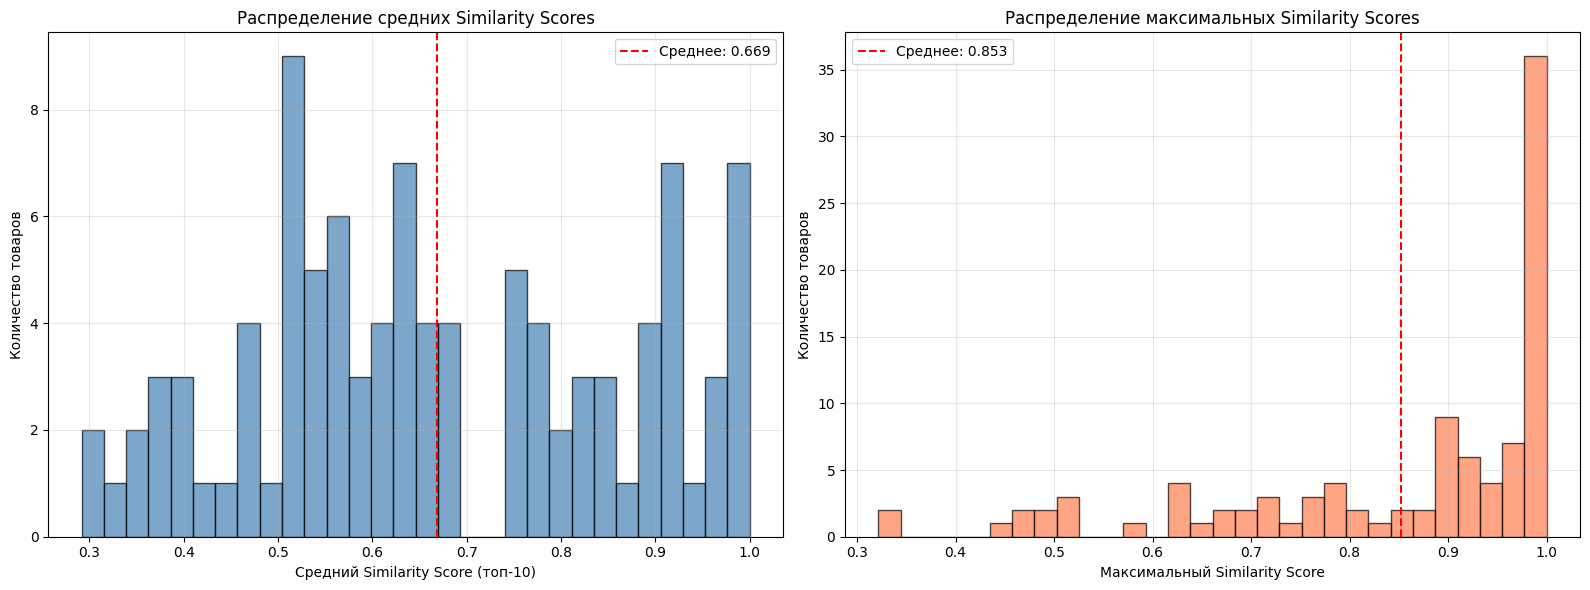


Статистика по выборке из 100 товаров:
Средний similarity score (топ-10 рекомендаций): 0.6690 ± 0.1936
Максимальный similarity score: 0.8525 ± 0.1756
Минимальный средний score: 0.2917
Максимальный средний score: 1.0000


In [104]:
sample_size = 100
sample_offers = tfidf_df.sample(sample_size, random_state=42)['offer_id'].values

avg_similarities = []
max_similarities = []

for offer_id in sample_offers:
    recs = get_tfidf_recommendations(offer_id, top_n=10)
    if recs is not None:
        avg_similarities.append(recs['similarity_score'].mean())
        max_similarities.append(recs['similarity_score'].max())

avg_similarities = np.array(avg_similarities)
max_similarities = np.array(max_similarities)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(avg_similarities, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(avg_similarities.mean(), color='red', linestyle='--',
               label=f'Среднее: {avg_similarities.mean():.3f}')
axes[0].set_xlabel('Средний Similarity Score (топ-10)')
axes[0].set_ylabel('Количество товаров')
axes[0].set_title('Распределение средних Similarity Scores')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(max_similarities, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(max_similarities.mean(), color='red', linestyle='--',
               label=f'Среднее: {max_similarities.mean():.3f}')
axes[1].set_xlabel('Максимальный Similarity Score')
axes[1].set_ylabel('Количество товаров')
axes[1].set_title('Распределение максимальных Similarity Scores')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nСтатистика по выборке из {sample_size} товаров:")
print(f"Средний similarity score (топ-10 рекомендаций): {avg_similarities.mean():.4f} ± {avg_similarities.std():.4f}")
print(f"Максимальный similarity score: {max_similarities.mean():.4f} ± {max_similarities.std():.4f}")
print(f"Минимальный средний score: {avg_similarities.min():.4f}")
print(f"Максимальный средний score: {avg_similarities.max():.4f}")

In [105]:
test_products = tfidf_df.sample(5, random_state=42)

for idx, product in test_products.iterrows():
    print(f"\n{'='*100}")
    print(f"Товар: {product['name'][:50]}...")
    print(f"Категория: {product['name_category']}")
    print(f"Производитель: {product['vendor']}")
    print(f"─" * 100)

    recs = get_tfidf_recommendations(product['offer_id'], top_n=5)

    if recs is not None:
        same_category = (recs['name_category'] == product['name_category']).sum()
        same_vendor = (recs['vendor'] == product['vendor']).sum()

        print(f"Рекомендаций из той же категории: {same_category}/5 ({same_category*20}%)")
        print(f"Рекомендаций того же производителя: {same_vendor}/5 ({same_vendor*20}%)")
        print(f"Средний similarity score: {recs['similarity_score'].mean():.4f}")
        print(f"\nТоп-3 рекомендации:")
        for i, rec in recs.head(3).iterrows():
            print(f"  • {rec['name'][:60]}... (score: {rec['similarity_score']:.3f})")


Товар: инструмент для снятия изоляции DUWI НТ-332 серый...
Категория: Инструмент электромонтажный
Производитель: DUWI
────────────────────────────────────────────────────────────────────────────────────────────────────
Рекомендаций из той же категории: 4/5 (80%)
Рекомендаций того же производителя: 2/5 (40%)
Средний similarity score: 0.4071

Топ-3 рекомендации:
  • инструмент для снятия изоляции DUWI PROF автоматический WS-0... (score: 0.460)
  • инструмент DUWI PROFI для снятия изоляции 0,5-6мм2 полуавтом... (score: 0.427)
  • клещи KENDO для снятия изоляции 160мм... (score: 0.392)

Товар: заглушка для кронштейна 420мм белая...
Категория: Системы для гардероба
Производитель: Не указана
────────────────────────────────────────────────────────────────────────────────────────────────────
Рекомендаций из той же категории: 5/5 (100%)
Рекомендаций того же производителя: 3/5 (60%)
Средний similarity score: 0.6639

Топ-3 рекомендации:
  • заглушка для кронштейна 325мм белая... (score: 1.000)
